# Preprocessing

This Notebook does the following preprocessing steps:
- Load data
- Add timestamp column
- Handle negative values (set them to 0)
- Handle missing values (add maintanance day column when all turbines have nan values for a whole day, )
- Handle unknown values (add turbine_stopped column and set Patv to nan for these samples, add turbine_at_rest column and set Patv to nan for these samples)
- Handle abnormal values (for very few outliers in Ndir and Wdir, set Patv to nan)
- save preprocessed data
- Visualize total power output per day

Note: this preprocessing is valid to do on the whole data set (train + validation) together as we do not modify the data on one part of the data set based on information from the other part of the data set (such as scaling). Transformations such as scaling will be fitted on the train set and applied to the validation set to avoid data leakage.


In [1]:
import pandas as pd
import yaml

## Load Config

In [2]:
# display current working directory
import os

os.getcwd()

'/Users/fischere/Library/CloudStorage/OneDrive-SchwarzIT/05 Learning/pprojects/windpark_forecasting_kdd22/windfarm_forecast/windfarm_forecast/notebooks'

In [3]:
# use config yaml file to set the parameters for the preprocessing
with open("../../config.yaml", "r") as file:
    config = yaml.safe_load(file)


## Load data


In [4]:
df = pd.read_csv("../../data/sdwpf_kddcup/sdwpf_245days_v1.csv")
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [5]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   TurbID   4727520 non-null  int64  
 1   Day      4727520 non-null  int64  
 2   Tmstamp  4727520 non-null  object 
 3   Wspd     4678002 non-null  float64
 4   Wdir     4678002 non-null  float64
 5   Etmp     4678002 non-null  float64
 6   Itmp     4678002 non-null  float64
 7   Ndir     4678002 non-null  float64
 8   Pab1     4678002 non-null  float64
 9   Pab2     4678002 non-null  float64
 10  Pab3     4678002 non-null  float64
 11  Prtv     4678002 non-null  float64
 12  Patv     4678002 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [6]:
# make pandas show 500 rows
pd.set_option("display.max_rows", 50)
df[:500]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,4,10:30,12.25,-1.47,24.72,38.35,40.18,1.07,1.07,1.07,-0.22,1542.44
496,1,4,10:40,12.03,-2.17,25.05,38.56,39.62,1.06,1.06,1.06,-0.18,1547.11
497,1,4,10:50,12.12,3.12,25.42,38.92,41.66,1.07,1.07,1.07,-0.20,1534.13
498,1,4,11:00,12.59,-2.71,25.70,39.17,46.08,1.08,1.08,1.08,-0.22,1540.59


## Preprocessing

### Add Timestamp column

In [7]:
# rename Tmstamp to time
df.rename(columns={"Tmstamp": "time"}, inplace=True)

In [8]:
# Create datetime column by combining Day and time

base_date = "2020-05-01"  # '2021-01-01'
# Add ':00' for seconds to the time strings and Convert Day and time columns to timestamp
df["timestamp"] = (
    pd.to_datetime(base_date) + pd.to_timedelta(df["Day"] - 1, unit="D") + pd.to_timedelta(df["time"] + ":00")
)

In [9]:
df.head()

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2020-05-01 00:10:00
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,2020-05-01 00:20:00
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,2020-05-01 00:30:00
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,2020-05-01 00:40:00


### Handle negative values

When a wind turbine is not producing power, the control system and sensors still draw power leading to negative values. This affects 25% of the data as we saw in the data exploration notebook, making this an important issue to handle.

In [10]:
# set all negatives values of Patv to 0
df.loc[df["Patv"] < 0, "Patv"] = 0

### Handle rows with missing values

Wind turbines are not always operational due to maintanance, too little wind or to avoid grid overload. This leads to missing values in the data that we need to handle.

Case: All turbines have nan values for a whole day.

In [11]:
# count the number of nan values for patv values grouped by day
df_patv_sum_per_day = df.groupby("Day")["Patv"].sum()

# sort ascending
df_patv_sum_per_day.sort_values(ascending=True)

Day
66            0.00
229        2738.18
209        9931.49
193      101082.45
192      213937.68
          ...     
95     21216066.96
203    22822188.98
150    23013791.31
206    23349848.00
96     23604407.42
Name: Patv, Length: 245, dtype: float64

Day 66 has 100% missing values. Mark this as maintance day.

In [12]:
df["maintenance_day"] = 0
df.loc[df["Day"] == 66, "maintenance_day"] = 1

In [13]:
# how much % nan values are there on the other low power outout days?
df[df["Day"] == 229]["Patv"].isna().sum() / len(df[df["Day"] == 229])  # 0.1% are nan values
df[df["Day"] == 209]["Patv"].isna().sum() / len(df[df["Day"] == 209])  # 0.06% are nan values
df[df["Day"] == 193]["Patv"].isna().sum() / len(df[df["Day"] == 193])  # 0.1% are nan values

np.float64(0.0010883084577114428)

In [14]:
# what is the average wind speed grouped by day?
df.groupby("Day")["Wspd"].mean().sort_values(ascending=True)

Day
193     0.992614
229     1.247060
209     1.424788
84      1.532374
192     1.595655
         ...    
199    11.559020
17     12.736796
142    13.269564
18     13.400698
66           NaN
Name: Wspd, Length: 245, dtype: float64

The following days (229, 209, 193, etc.) have normal missing values rates but very low wind speeds. These do not require special handling.

In [15]:
df_patvnan = df[df["Patv"].isna()]

# check value distribution for all columns
df_patvnan.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day
count,49518.000000,49518.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49518,49518.000000
mean,69.415324,84.198009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-23 14:54:10.405913088,0.389676
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00,0.000000
25%,35.000000,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 06:20:00,0.000000
50%,69.000000,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 21:45:00,0.000000
75%,105.000000,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-06 13:10:00,1.000000
max,134.000000,245.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-31 23:50:00,1.000000
std,39.789099,48.264468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487682


In [16]:
# on day 66, turbine 1 has all nan values. How about the other turbines?
df[df["Day"] == 66].describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day
count,19296.000000,19296.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19296,19296.0
mean,67.500000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 11:55:00,1.0
min,1.000000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 00:00:00,1.0
25%,34.000000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 05:57:30,1.0
50%,67.500000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 11:55:00,1.0
75%,101.000000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 17:52:30,1.0
max,134.000000,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-05 23:50:00,1.0
std,38.682393,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


When 'Patv' is nan, the other columns are also nan, indicating that the whole 

In [17]:
# are the nan values for Patv?
df[df["Patv"].isna()]


# make pandas display 10000 rows
# pd.set_option('display.max_rows', 10000)
# show 1000 rows
df[df["Patv"].isna()].head(1000)

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00,0
1440,1,11,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-11 00:00:00,0
2880,1,21,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-21 00:00:00,0
3694,1,26,15:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-26 15:40:00,0
4320,1,31,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-31 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80123,3,67,09:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-06 09:50:00,0
80124,3,67,10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-06 10:00:00,0
80125,3,67,10:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-06 10:10:00,0
80126,3,67,10:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-06 10:20:00,0


### Handle rows with unknown values

Case 1: Turbine stopped for some reason

In [18]:
# When Patv≤0, and Wspd > 2.5 at time t, the turbine is stopped for some reason (since wind speed was actually large enough to produce power)

turbine_stopped_mask = (df["Patv"] <= 0) & (df["Wspd"] > 2.5)

# create turbine_stopped column
df["turbine_stopped"] = 0
df.loc[turbine_stopped_mask, "turbine_stopped"] = 1

# when turbine_stopped is 1, set Patv to nan
df.loc[df["turbine_stopped"] == 1, "Patv"] = None

In [19]:
df[df["turbine_stopped"] == 1]

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day,turbine_stopped
83,1,1,13:50,5.72,0.08,37.24,48.74,67.22,1.86,1.86,1.86,-0.30,NaN,2020-05-01 13:50:00,0,1
84,1,1,14:00,5.72,-43.83,37.59,49.22,81.45,1.90,1.90,1.90,-0.30,NaN,2020-05-01 14:00:00,0,1
85,1,1,14:10,3.97,-62.36,38.09,49.56,81.45,1.90,1.90,1.90,-0.30,NaN,2020-05-01 14:10:00,0,1
86,1,1,14:20,3.25,-22.98,38.58,49.93,81.45,1.90,1.90,1.90,-0.30,NaN,2020-05-01 14:20:00,0,1
87,1,1,14:30,6.34,-29.70,38.96,50.13,81.45,1.90,1.90,1.90,-0.30,NaN,2020-05-01 14:30:00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727038,134,242,15:40,2.52,105.18,1.45,5.41,59.98,90.30,90.38,90.29,-0.30,NaN,2020-12-28 15:40:00,0,1
4727041,134,242,16:10,3.28,24.53,1.36,4.45,155.00,73.15,73.20,73.13,-0.27,NaN,2020-12-28 16:10:00,0,1
4727043,134,242,16:30,2.53,-3.70,1.94,6.36,178.59,90.39,90.15,90.39,-0.30,NaN,2020-12-28 16:30:00,0,1
4727185,134,243,16:10,6.59,-2.90,-1.84,1.84,378.19,89.81,89.83,89.44,0.37,NaN,2020-12-29 16:10:00,0,1


Case 2: Pab > 89, the turbine is at rest

In [20]:
pab_mask = (df["Pab1"] > 89) | (df["Pab2"] > 89) | (df["Pab3"] > 89)

# df[pab_mask].describe()
# df[pab_mask].head(1000)

# visualize the power output of the turbines at rest per day
# df[pab_mask].groupby('Day')['Patv'].sum().plot()  # only 4-5 days where power output is significant although turbine is at rest

In [21]:
# set Patv to nan when pab indicates that the turbine is at rest
df.loc[pab_mask, "Patv"] = None

# add a column indicating that the turbine is at rest
df["turbine_at_rest"] = 0
df.loc[pab_mask, "turbine_at_rest"] = 1

df[pab_mask]

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day,turbine_stopped,turbine_at_rest
29818,1,208,01:40,1.12,-7.16,2.00,25.77,13.76,89.65,90.01,89.96,-0.3,NaN,2020-11-24 01:40:00,0,0,1
29819,1,208,01:50,0.96,-7.68,1.34,25.20,13.76,90.02,90.39,90.33,-0.3,NaN,2020-11-24 01:50:00,0,0,1
29820,1,208,02:00,0.79,-2.93,0.88,24.75,13.76,90.02,90.39,90.33,-0.3,NaN,2020-11-24 02:00:00,0,0,1
29821,1,208,02:10,0.42,9.78,0.65,24.39,13.76,90.02,90.39,90.33,-0.3,NaN,2020-11-24 02:10:00,0,0,1
29822,1,208,02:20,0.46,44.67,0.40,24.22,13.76,90.02,90.39,90.33,-0.3,NaN,2020-11-24 02:20:00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727391,134,245,02:30,0.71,-104.26,-6.42,0.80,306.46,90.39,90.10,90.37,-0.3,NaN,2020-12-31 02:30:00,0,0,1
4727392,134,245,02:40,0.88,-125.54,-6.28,0.71,306.46,90.39,90.10,90.37,-0.3,NaN,2020-12-31 02:40:00,0,0,1
4727393,134,245,02:50,1.28,-101.70,-5.91,0.52,306.46,90.39,90.10,90.37,-0.3,NaN,2020-12-31 02:50:00,0,0,1
4727394,134,245,03:00,1.38,-99.43,-5.46,0.24,306.46,90.39,90.10,90.37,-0.3,NaN,2020-12-31 03:00:00,0,0,1


<Axes: xlabel='Day'>

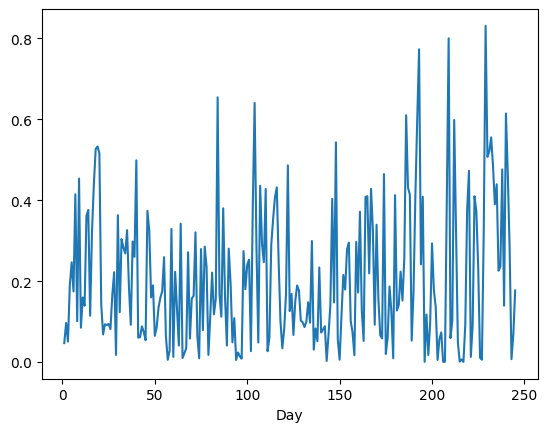

In [22]:
# are there relevant wind speeds where the turbine is at rest?
df[df["turbine_at_rest"] == 1]["Wspd"].describe()

# how many days are there where a turbine is at rest? This is normal and happens nearly every day to some extent.
df[df["turbine_at_rest"] == 1]["Day"].nunique()

# how many samples per day are there where a turbine is at rest?
df[df["turbine_at_rest"] == 1].groupby("Day")["time"].count().sort_values(ascending=True)

# plot the percentage of samples per day when turbine is at rest
samples_per_day = float(df.groupby("Day")["time"].count().mean())
(df[df["turbine_at_rest"] == 1].groupby("Day")["time"].count() / samples_per_day).plot()

In [23]:
len(df[df["turbine_stopped"] == 1]) / len(df)

0.06326657528683115

In 6% of the samples, a turbine is stopped for some reason though there is enough wind. As we want to predict potential power output, we will impute these values (we should do that on the individual turbine level with some interpolation or other technique, e.g. using the output of the most similar turbine instead). The imputation will be done in the feature engineering notebook.

## Handle abnormal values

Case 1: Ndir
Samples with Ndir > 720 or Ndir < -720 are abnormal. Only 49 samples are affected

In [24]:
ndir_mask = (df["Ndir"] > 720) | (df["Ndir"] < -720)

# set Patv to nan for these samples
df.loc[ndir_mask, "Patv"] = None

Case 2: Wdir
Samples with Wdir > 180 or Wdir < -180 are abnormal. Only 78 samples are affected

In [25]:
wdir_mask = (df["Wdir"] > 180) | (df["Wdir"] < -180)

df[wdir_mask]
# set Patv to nan for these samples
df.loc[wdir_mask, "Patv"] = None

In [26]:
# create output directory if it does not exist
import os

os.makedirs("../../data/modified", exist_ok=True)

# Save preprocessed data
df.to_parquet("../../data/modified/sdwpf_245days_v1_preprocessed.parquet")

## Visualize total power output per day


Text(0, 0.5, 'Total Power Output (Patv)')

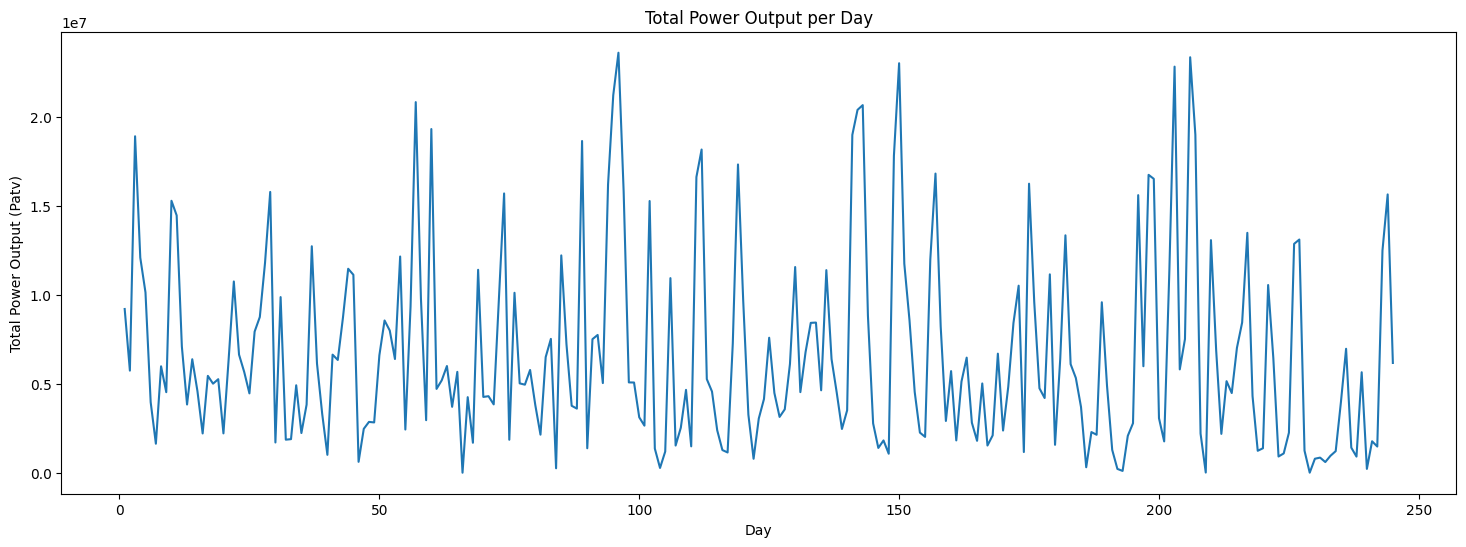

In [27]:
import matplotlib.pyplot as plt

# Create figure with larger width
plt.figure(figsize=(18, 6))  # Width is now 18 inches (3x wider), height remains 6 inches

# plot total power output per day
df.groupby("Day")["Patv"].sum().plot()
plt.title("Total Power Output per Day")
plt.xlabel("Day")
plt.ylabel("Total Power Output (Patv)")

In [28]:
import matplotlib.pyplot as plt

In [29]:
df.head()

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day,turbine_stopped,turbine_at_rest
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00,0,0,0
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2020-05-01 00:10:00,0,0,0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,2020-05-01 00:20:00,0,0,0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,2020-05-01 00:30:00,0,0,0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,2020-05-01 00:40:00,0,0,0


## Visualize power output per turbine per day

In [30]:
import plotly.express as px
import plotly.graph_objects as go

# Convert the grouped data to a format plotly can use
plot_data = df.groupby(["Day", "TurbID"])["Patv"].sum().reset_index()

# Calculate mean and standard deviation per day across all turbines
daily_stats = plot_data.groupby("Day")["Patv"].agg(["mean", "std"]).reset_index()
daily_stats["upper_bound"] = daily_stats["mean"] + 3 * daily_stats["std"]
daily_stats["lower_bound"] = daily_stats["mean"] - 3 * daily_stats["std"]

# Create the plot using plotly
fig = px.line(plot_data, x="Day", y="Patv", color="TurbID", title="Power Output per Turbine per Day")

# Add confidence interval bands
fig.add_trace(
    go.Scatter(
        x=daily_stats["Day"].tolist() + daily_stats["Day"].tolist()[::-1],
        y=daily_stats["upper_bound"].tolist() + daily_stats["lower_bound"].tolist()[::-1],
        fill="toself",
        fillcolor="rgba(0,100,80,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="3σ Confidence Interval",
    )
)

# Customize the plot
fig.update_layout(
    xaxis_title="Day",
    yaxis_title="Power Output (Patv)",
    showlegend=True,
    width=1800,  # Approximate equivalent to figsize=(30,6)
    height=600,  # Increased by 50% from 400 to 600
    template="plotly_white",  # Clean white background with grid
)

# Show the plot
fig.show()

## Add impute_day_patv column

For days where the power output is zero and the lower bound (mu - 3 sigma) is greater than 0 (meaning we have an anomalous day for a turbine where it does not produce power even though it should according to the other turbines state), we mark the samples of the 0 output turbine with an imputation column for later. This is done to estimate the potential power output of the wind farm.

The visual analysis above showed that these cases are quite rare but can occur over several days for a specific turbine. It adresses especially cases where very few turbines are at maintanance or shut down for some other reason 

In [31]:
# join daily_stats to plot_data
daily_data = plot_data.merge(daily_stats, on="Day")

# identify days where the power output is zero and the lower bound is greater than 0: add impute_day_patv column
daily_data["impute_day_patv"] = 0
daily_data.loc[(daily_data["Patv"] == 0) & (daily_data["lower_bound"] > 0), "impute_day_patv"] = 1

In [32]:
daily_data.head()

,Day,TurbID,Patv,mean,std,upper_bound,lower_bound,impute_day_patv
0,1,1,120170.39,68665.213507,12562.518588,106352.769272,30977.657743,0
1,1,2,73436.93,68665.213507,12562.518588,106352.769272,30977.657743,0
2,1,3,79778.84,68665.213507,12562.518588,106352.769272,30977.657743,0
3,1,4,85525.33,68665.213507,12562.518588,106352.769272,30977.657743,0
4,1,5,79730.58,68665.213507,12562.518588,106352.769272,30977.657743,0


In [33]:
daily_data[(daily_data["impute_day_patv"] == 1) & (daily_data["TurbID"] == 13)].sort_values(
    by=["TurbID", "Day"], ascending=[True, True]
)

,Day,TurbID,Patv,mean,std,upper_bound,lower_bound,impute_day_patv
548,5,13,0.0,75627.885224,18446.741058,130968.108398,20287.662050,1
682,6,13,0.0,29586.857239,7167.526127,51089.435621,8084.278857,1
816,7,13,0.0,12164.697388,3986.531270,24124.291197,205.103579,1
950,8,13,0.0,44629.107985,9490.190673,73099.680003,16158.535967,1
3898,30,13,0.0,12683.784478,3442.142661,23010.212462,2357.356493,1


In [34]:
# join the impute_day_patv column to the df
df = df.merge(daily_data[["Day", "TurbID", "impute_day_patv"]], on=["Day", "TurbID"], how="left")
df.head()

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day,turbine_stopped,turbine_at_rest,impute_day_patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00,0,0,0,0
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2020-05-01 00:10:00,0,0,0,0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,2020-05-01 00:20:00,0,0,0,0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,2020-05-01 00:30:00,0,0,0,0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,2020-05-01 00:40:00,0,0,0,0


In [35]:
# only show unique (Day, TurbID) samples
df[(df["impute_day_patv"] == 1) & (df["TurbID"] == 13)][["Day", "TurbID", "Patv", "impute_day_patv"]].drop_duplicates()

,Day,TurbID,Patv,impute_day_patv
423936,5,13,NaN,1
424080,6,13,NaN,1
424224,7,13,NaN,1
424368,8,13,NaN,1
424370,8,13,0.0,1
427536,30,13,NaN,1


In [36]:
df.to_parquet("../../data/modified/sdwpf_245days_v1_preprocessed_impute_rdy.parquet")

No Trend visible. Thus, we can analyez the autocorrelation plot next (if there was a trend, one should remove it before analyzing the autocorrelation plot). 

## Check Applicability of Linear Models

If the time series is stationary, linear models are sufficient to model the time series. A test for stationarity is the Augmented Dickey-Fuller test which is evaluated below

In [37]:
# check the stationarity of the power output time series
from statsmodels.tsa.stattools import adfuller

p_value_adfuller = adfuller(df.groupby("Day")["Patv"].sum())

In [38]:
p_value_adfuller[1]

np.float64(1.6350445518651116e-18)

Time series is stationary with a confidence of over 99%. Thus, we can use models such as arima, linear reg etc without any further preprocessing.

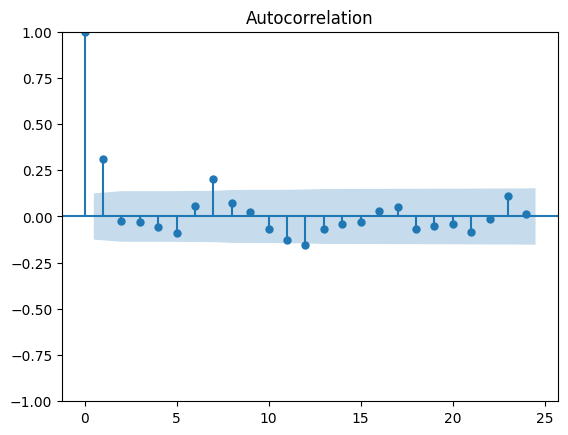

In [39]:
# plot autocorrelation of the power output time series
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df.groupby("Day")["Patv"].sum())
plt.show()

The autocorrelation plot shows no significant autocorrelation. This is not surprising as mainy external factors such as wind speed and wind direction determine the power output.

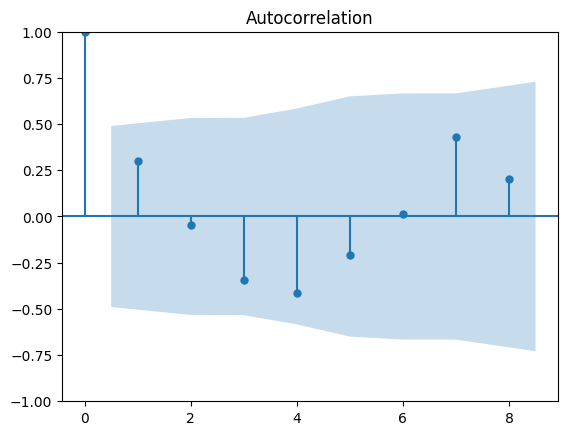

In [40]:
# plot autocorrelation  of the power output time series for the first 16 days
plot_acf(df.groupby("Day")["Patv"].sum().iloc[:16])
plt.show()

Same when just looking at the first 14 + 2 = 16 days (the setting of the kdd challenge is max 14 days of input sequence to forecast 2 days ahead).

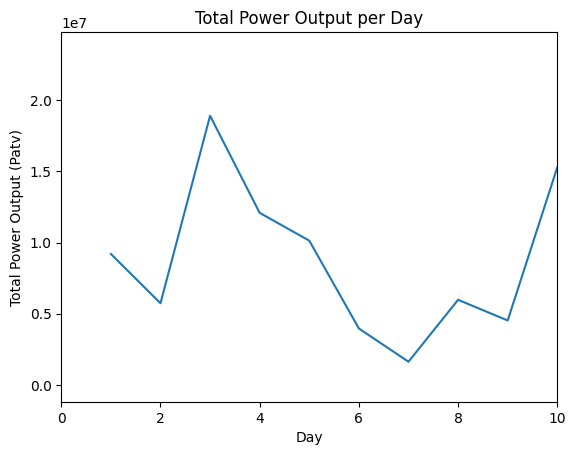

In [41]:
# plot total power output per day for Days 0 to 10
df.groupby("Day")["Patv"].sum().plot()
plt.title("Total Power Output per Day")
plt.xlabel("Day")
plt.ylabel("Total Power Output (Patv)")
plt.xlim(0, 10)
plt.show()

In [42]:
df[df["timestamp"] < pd.Timestamp("2021-01-10")]

,TurbID,Day,time,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,timestamp,maintenance_day,turbine_stopped,turbine_at_rest,impute_day_patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-01 00:00:00,0,0,0,0
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2020-05-01 00:10:00,0,0,0,0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2020-05-01 00:20:00,0,0,0,0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2020-05-01 00:30:00,0,0,0,0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2020-05-01 00:40:00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44,2020-12-31 23:10:00,0,0,0,0
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79,2020-12-31 23:20:00,0,0,0,0
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36,2020-12-31 23:30:00,0,0,0,0
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89,2020-12-31 23:40:00,0,0,0,0


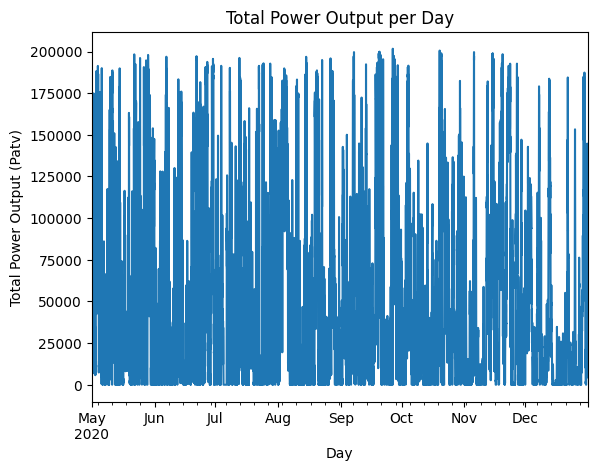

In [43]:
# plot total power output grouped by timestamp for the first 5 days

df_plot = df[df["timestamp"] < pd.Timestamp("2021-01-03")]

df_plot.groupby("timestamp")["Patv"].sum().plot()
plt.title("Total Power Output per Day")
plt.xlabel("Day")
plt.ylabel("Total Power Output (Patv)")
plt.show()

In [44]:
# limit pandas output to 50 rows
pd.set_option("display.max_rows", 50)

# calculate for each day the proportion of samples with turbine_stopped = 1, sort descending
df.groupby("Day")["turbine_stopped"].mean().sort_values(ascending=False)

Day
19     0.642413
18     0.629923
20     0.615568
17     0.526068
5      0.302032
         ...   
206    0.003524
236    0.003420
215    0.001347
217    0.000415
66     0.000000
Name: turbine_stopped, Length: 245, dtype: float64

Notes
- idea: only use top n turbines for training (w.r.t. power output) as this models the potential power output